# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [1]:
def get_random_rdir():
    r = np.random.uniform(low=30.0, high=50.0)
    az = np.random.uniform(low=0., high=2*np.pi)
    return r, (np.cos(az), np.sin(az))

In [1]:
## TODO: Train your agent here.
%load_ext autoreload
%autoreload 2

import sys
import csv
import pandas as pd
import numpy as np
from agents.DDPGagent import DDPG
from task_AC import Task

num_episodes = 200
runtime = 5.                           # time limit of the episode
init_pose = np.zeros(6)                # initial pose
init_pose[2] = 10.                     # pose z-value, start off the ground.
init_velocities = np.zeros(3)          # initial velocities
init_angle_velocities = np.zeros(3)    # initial angle velocities
target_pos = np.zeros(3)               # to be replaced on a per-episode basis

task = Task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)
agent = DDPG(task) 

labels = ['time', 'i_episode', 'tgt_x', 'tgt_y', 'tgt_z', 'rewards', 'noise_scale', 'x', 'y', 'z', 
          'phi', 'theta', 'psi', 'dx', 'dy', 'dz', 'vx', 'vy', 'vz', 'v_phi', 'v_theta','v_psi',
          'thrustx', 'thrusty', 'thrustz', 'central_rotor_hz', 'dhz_rotor1', 'dhz_rotor2', 'dhz_rotor3', 'dhz_rotor4',
          'delta_reward_from_max']
res = []

file_output = 'data.txt'  # file name for saved results

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)

    for i_episode in range(1, num_episodes+1):
        res.append({x : [] for x in labels})
        
        #r, dir = get_random_rdir()         # select random target location
        #new_target_pos = np.array([r*dir[0], r*dir[1], 0.]) + init_pose[:3]
        new_target_pos = np.array([0., 0., 10.])  # take-off only

        state = agent.reset_episode(new_target_pos)  # start a new episode
        
        while True:
            action = agent.act(state) 
            next_state, reward, done = task.step(action)
            agent.step(action, reward, next_state, done)
            state = next_state
            
            # Monitoring - switch angles to -180..180
            myangs = np.copy(task.sim.pose[3:])
            myangv = np.copy(task.sim.angular_v)
            myangs = np.where((myangs > np.pi), myangs-2*np.pi, myangs )
            myangv = np.where((myangv > np.pi), myangv-2*np.pi, myangv )
            myangs *= 180/np.pi
            myangv *= 180/np.pi
            to_write = [task.sim.time] + [i_episode] + list(task.target_pos) + \
                        [np.mean(reward)] + [agent.noise.state] + list(task.sim.pose[:3]) + list(myangs) + \
                        list(task.sim.pose[:3]-task.target_pos) + list(task.sim.v) + \
                        list(myangv) + list(task.sim.thrustplusdrag) + list(action) + [reward - task.get_max_reward()]
            for ii in range(len(labels)):
                res[i_episode-1][labels[ii]].append(to_write[ii])
            writer.writerow(to_write)
            if done:
                print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f})".format(
                    i_episode, agent.score, agent.best_score), end="")  # [debug]
                break
        sys.stdout.flush()

Using TensorFlow backend.


Episode =  200, score =   1.879 (best =   2.892)

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

In [11]:
print(res[4]['time'][-1])

0.48000000000000015


In [26]:

rotor_speeds = np.array([res[0]['dhz_rotor1'][0],res[0]['dhz_rotor2'][0],
                         res[0]['dhz_rotor3'][0],res[0]['dhz_rotor4'][0]]) + res[0]['central_rotor_hz'][0]
angular_v=np.zeros(3)
angles=np.zeros(3)
for _ in range(3):
    thrusts = task.sim.get_propeler_thrust(rotor_speeds)
    thrust_moment = np.array([(thrusts[3] - thrusts[2]) * task.sim.l_to_rotor,
                            (thrusts[1] - thrusts[0]) * task.sim.l_to_rotor,
                            0])
    angular_accels = thrust_moment / task.sim.moments_of_inertia
    angular_v = angular_v + angular_accels*task.sim.dt
    angles = angles + angular_v * task.sim.dt + 0.5 * angular_accels * task.sim.dt**2
    angles = (angles + 2 * np.pi) % (2 * np.pi)

    print('rotors: ', rotor_speeds)
    print('thrusts: ',thrusts)
    print('moments: ', thrust_moment)
    print('accels: ', angular_accels)
    print('ang_vs: ', angular_v)
    print('angles: ', angles)

rotors:  [ 431.38522401  430.23142586  430.20538099  429.15819515]
thrusts:  [2.6797422455772684, 2.6654267490989167, 2.6651040455652817, 2.6521452930730818]
moments:  [-0.0051835 -0.0057262  0.       ]
accels:  [-0.20591146 -0.2274698   0.        ]
ang_vs:  [-0.00411823 -0.0045494   0.        ]
angles:  [ 6.28306176  6.28304883  0.        ]
rotors:  [ 431.38522401  430.23142586  430.20538099  429.15819515]
thrusts:  [2.6797422455772684, 2.6654267490989167, 2.6651040455652817, 2.6521452930730818]
moments:  [-0.0051835 -0.0057262  0.       ]
accels:  [-0.20591146 -0.2274698   0.        ]
ang_vs:  [-0.00823646 -0.00909879  0.        ]
angles:  [ 6.28285585  6.28282136  0.        ]
rotors:  [ 431.38522401  430.23142586  430.20538099  429.15819515]
thrusts:  [2.6797422455772684, 2.6654267490989167, 2.6651040455652817, 2.6521452930730818]
moments:  [-0.0051835 -0.0057262  0.       ]
accels:  [-0.20591146 -0.2274698   0.        ]
ang_vs:  [-0.01235469 -0.01364819  0.        ]
angles:  [ 6.28

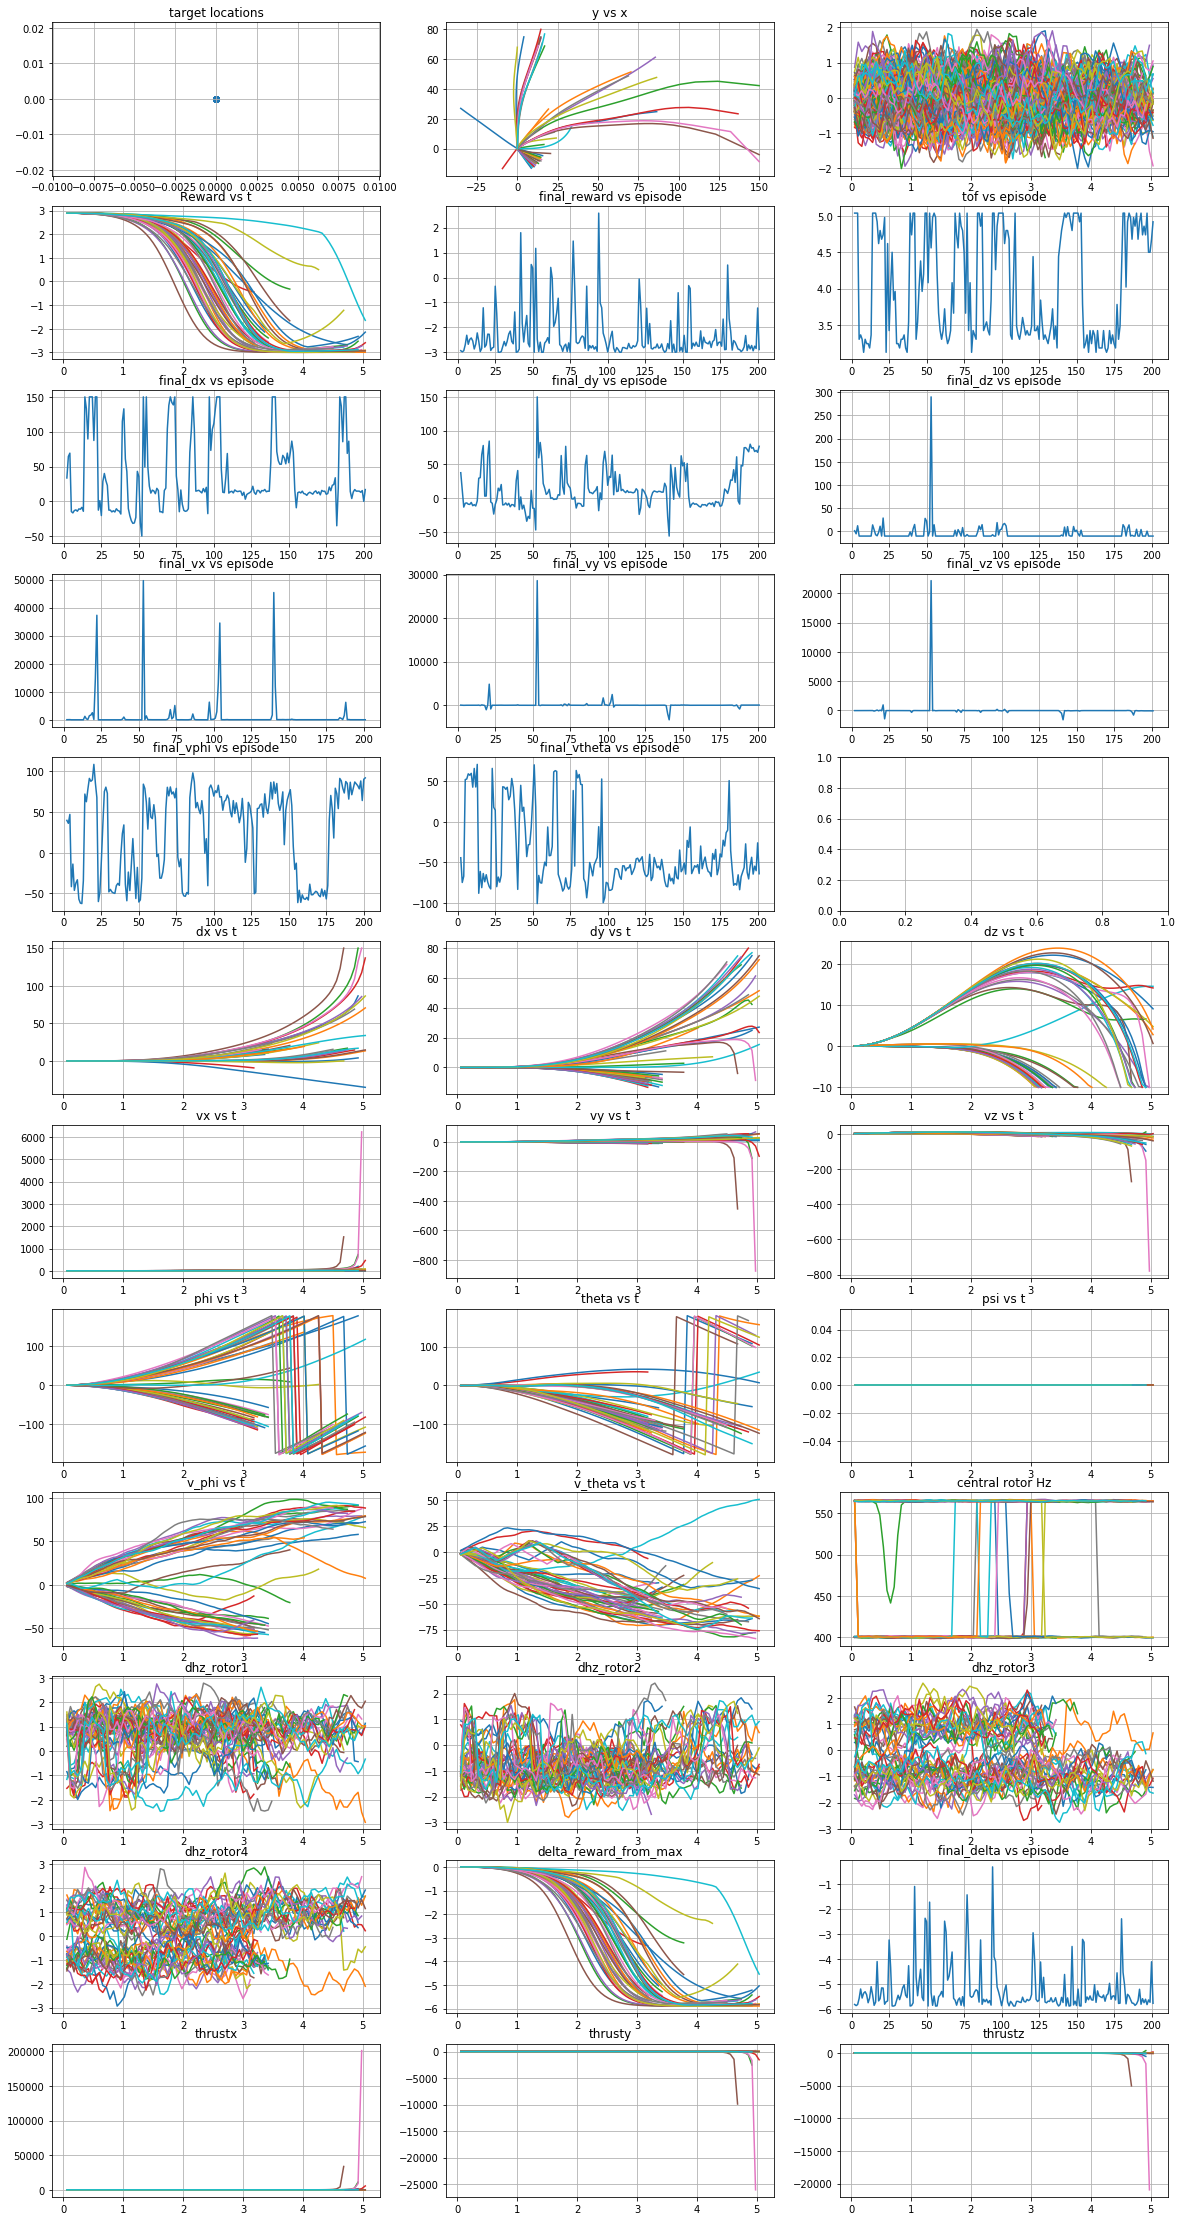

In [23]:
    ## TODO: Plot the rewards.
import matplotlib.pyplot as plt

titles = [
    ['target locations', 'y vs x', 'noise scale'],
    ['Reward vs t', 'final_reward vs episode', 'tof vs episode'],
    ['final_dx vs episode','final_dy vs episode','final_dz vs episode'],
    ['final_vx vs episode','final_vy vs episode','final_vz vs episode'],
    ['final_vphi vs episode','final_vtheta vs episode',''],
    ['dx vs t','dy vs t','dz vs t'],
    ['vx vs t','vy vs t','vz vs t'],
    ['phi vs t','theta vs t','psi vs t'],
    ['v_phi vs t','v_theta vs t', 'central rotor Hz'],  #'v_psi vs t'], nothing going on with psi
    ['dhz_rotor1', 'dhz_rotor2','dhz_rotor3'],
    ['dhz_rotor4', 'delta_reward_from_max','final_delta vs episode'],
    ['thrustx', 'thrusty', 'thrustz']
]
nrows=len(titles)
ncols=len(titles[0])
fig, subs = plt.subplots(nrows,ncols,figsize=(20,40))
for i in range(nrows):
        for j in range(ncols):
            subs[i,j].set_title(titles[i][j])
            subs[i,j].grid()
            
totrange = range(num_episodes)

n=50
myrange = range(num_episodes-n,num_episodes)
#myrange = range(1,n)
#myrange = [180]
#myrange = totrange
#totrange = myrange

for i in myrange:
        #subs[0,0].plot(-np.log(-1*np.array(res[0]['rewards'])), label='Reward')
        subs[0,1].plot(res[i]['x'], res[i]['y'], label='y vs x')
        subs[0,2].plot(res[i]['time'], res[i]['noise_scale'], label='noise_scale')
        subs[1,0].plot(res[i]['time'], res[i]['rewards'], label='Reward')
        subs[5,0].plot(res[i]['time'], res[i]['dx'], label='dx')
        subs[5,1].plot(res[i]['time'], res[i]['dy'], label='dy')
        subs[5,2].plot(res[i]['time'], res[i]['dz'], label='dz')
        subs[6,0].plot(res[i]['time'], res[i]['vx'], label='vx')
        subs[6,1].plot(res[i]['time'], res[i]['vy'], label='vy')
        subs[6,2].plot(res[i]['time'], res[i]['vz'], label='vz')
        subs[7,0].plot(res[i]['time'], res[i]['phi'], label='phi')
        subs[7,1].plot(res[i]['time'], res[i]['theta'], label='theta')
        subs[7,2].plot(res[i]['time'], res[i]['psi'], label='psi')
        subs[8,0].plot(res[i]['time'], res[i]['v_phi'], label='v_phi')
        subs[8,1].plot(res[i]['time'], res[i]['v_theta'], label='v_theta')
        subs[8,2].plot(res[i]['time'], res[i]['central_rotor_hz'], label='central_rotor_hz')
        subs[9,0].plot(res[i]['time'], res[i]['dhz_rotor1'], label='dv_rotor1')
        subs[9,1].plot(res[i]['time'], res[i]['dhz_rotor2'], label='dv_rotor2')
        subs[9,2].plot(res[i]['time'], res[i]['dhz_rotor3'], label='dv_rotor3')
        subs[10,0].plot(res[i]['time'], res[i]['dhz_rotor4'], label='dv_rotor4')
        subs[10,1].plot(res[i]['time'], res[i]['delta_reward_from_max'], label='delta_reward_from_max')
        subs[11,0].plot(res[i]['time'], res[i]['thrustx'], label='thrustx')
        subs[11,1].plot(res[i]['time'], res[i]['thrusty'], label='thrusty')
        subs[11,2].plot(res[i]['time'], res[i]['thrustz'], label='thrustz')

tgt_xs    = [res[i]['tgt_x'][0] for i in totrange]
tgt_ys    = [res[i]['tgt_y'][0] for i in totrange];    subs[0,0].scatter(tgt_xs, tgt_ys, label='target_locs')

episodes  = [res[i]['i_episode'][0]+1 for i in totrange]
tofs      = [res[i]['time'][-1] for i in totrange];      subs[1,2].plot(episodes, tofs, label='tof')
final_xs  = [res[i]['dx'][-1] for i in totrange];        subs[2,0].plot(episodes, final_xs, label='final_dx')
final_ys  = [res[i]['dy'][-1] for i in totrange];        subs[2,1].plot(episodes, final_ys, label='final_dy')
final_zs  = [res[i]['dz'][-1] for i in totrange];        subs[2,2].plot(episodes, final_zs, label='final_dz')
final_vxs = [res[i]['vx'][-1] for i in totrange];        subs[3,0].plot(episodes, final_vxs, label='final_vx')
final_vys = [res[i]['vy'][-1] for i in totrange];        subs[3,1].plot(episodes, final_vys, label='final_vy')
final_vzs = [res[i]['vz'][-1] for i in totrange];        subs[3,2].plot(episodes, final_vzs, label='final_vz')
final_vphis = [res[i]['v_phi'][-1] for i in totrange];   subs[4,0].plot(episodes, final_vphis, label='final_v_phi')
final_vthts = [res[i]['v_theta'][-1] for i in totrange]; subs[4,1].plot(episodes, final_vthts, label='final_v_theta')
final_rwd = [res[i]['rewards'][-1] for i in totrange];   subs[1,1].plot(episodes, final_rwd, label='final_rwd')
delta_rwd = [res[i]['delta_reward_from_max'][-1] for i in totrange]; subs[10,2].plot(episodes, delta_rwd, label='delta_rwd')

## Try task without pitch/roll control

In [10]:
## TODO: Train your agent here.
%load_ext autoreload
%autoreload 2

import sys
import csv
import pandas as pd
import numpy as np
from agents.DDPGagent import DDPG
from task_AC_nopitchroll import Task

num_episodes = 1000
runtime = 5.                           # time limit of the episode
init_pose = np.zeros(6)                # initial pose
init_velocities = np.zeros(3)          # initial velocities
init_angle_velocities = np.zeros(3)    # initial angle velocities
target_pos = np.zeros(3)               # to be replaced on a per-episode basis

task = Task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)
agent = DDPG(task) 

labels = ['time', 'i_episode', 'tgt_z', 'rewards', 'noise_scale', 'z', 
          'dz', 'vz', 'thrustz', 'dhz_rotor1']
res = []

file_output = 'data.csv'  # file name for saved results

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)

    for i_episode in range(1, num_episodes+1):
        res.append({x : [] for x in labels})
        
        #r, dir = get_random_rdir()         # select random target location
        #new_target_pos = np.array([r*dir[0], r*dir[1], 0.]) + init_pose[:3]
        new_target_pos = np.array([0., 0., 10.])  # take-off only

        state = agent.reset_episode(new_target_pos)  # start a new episode
        
        while True:
            action = agent.act(state) 
            next_state, reward, done = task.step(action)
            agent.step(action, reward, next_state, done)
            state = next_state
            
            # Monitoring
            to_write = [task.sim.time] + [i_episode] + [task.target_pos[2]] + \
                        [np.mean(reward)] + list(agent.noise.state) + [task.sim.pose[2]] + \
                        [task.sim.pose[2]-task.target_pos[2]] + [task.sim.v[2]] + \
                        [task.sim.thrustplusdrag[2]] + [action]
            for ii in range(len(labels)):
                res[i_episode-1][labels[ii]].append(to_write[ii])
            writer.writerow(to_write)
            if done:
                print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f})".format(
                    i_episode, agent.score, agent.best_score), end="")  # [debug]
                break
        sys.stdout.flush()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode = 1000, score =  -1.115 (best =   0.300)

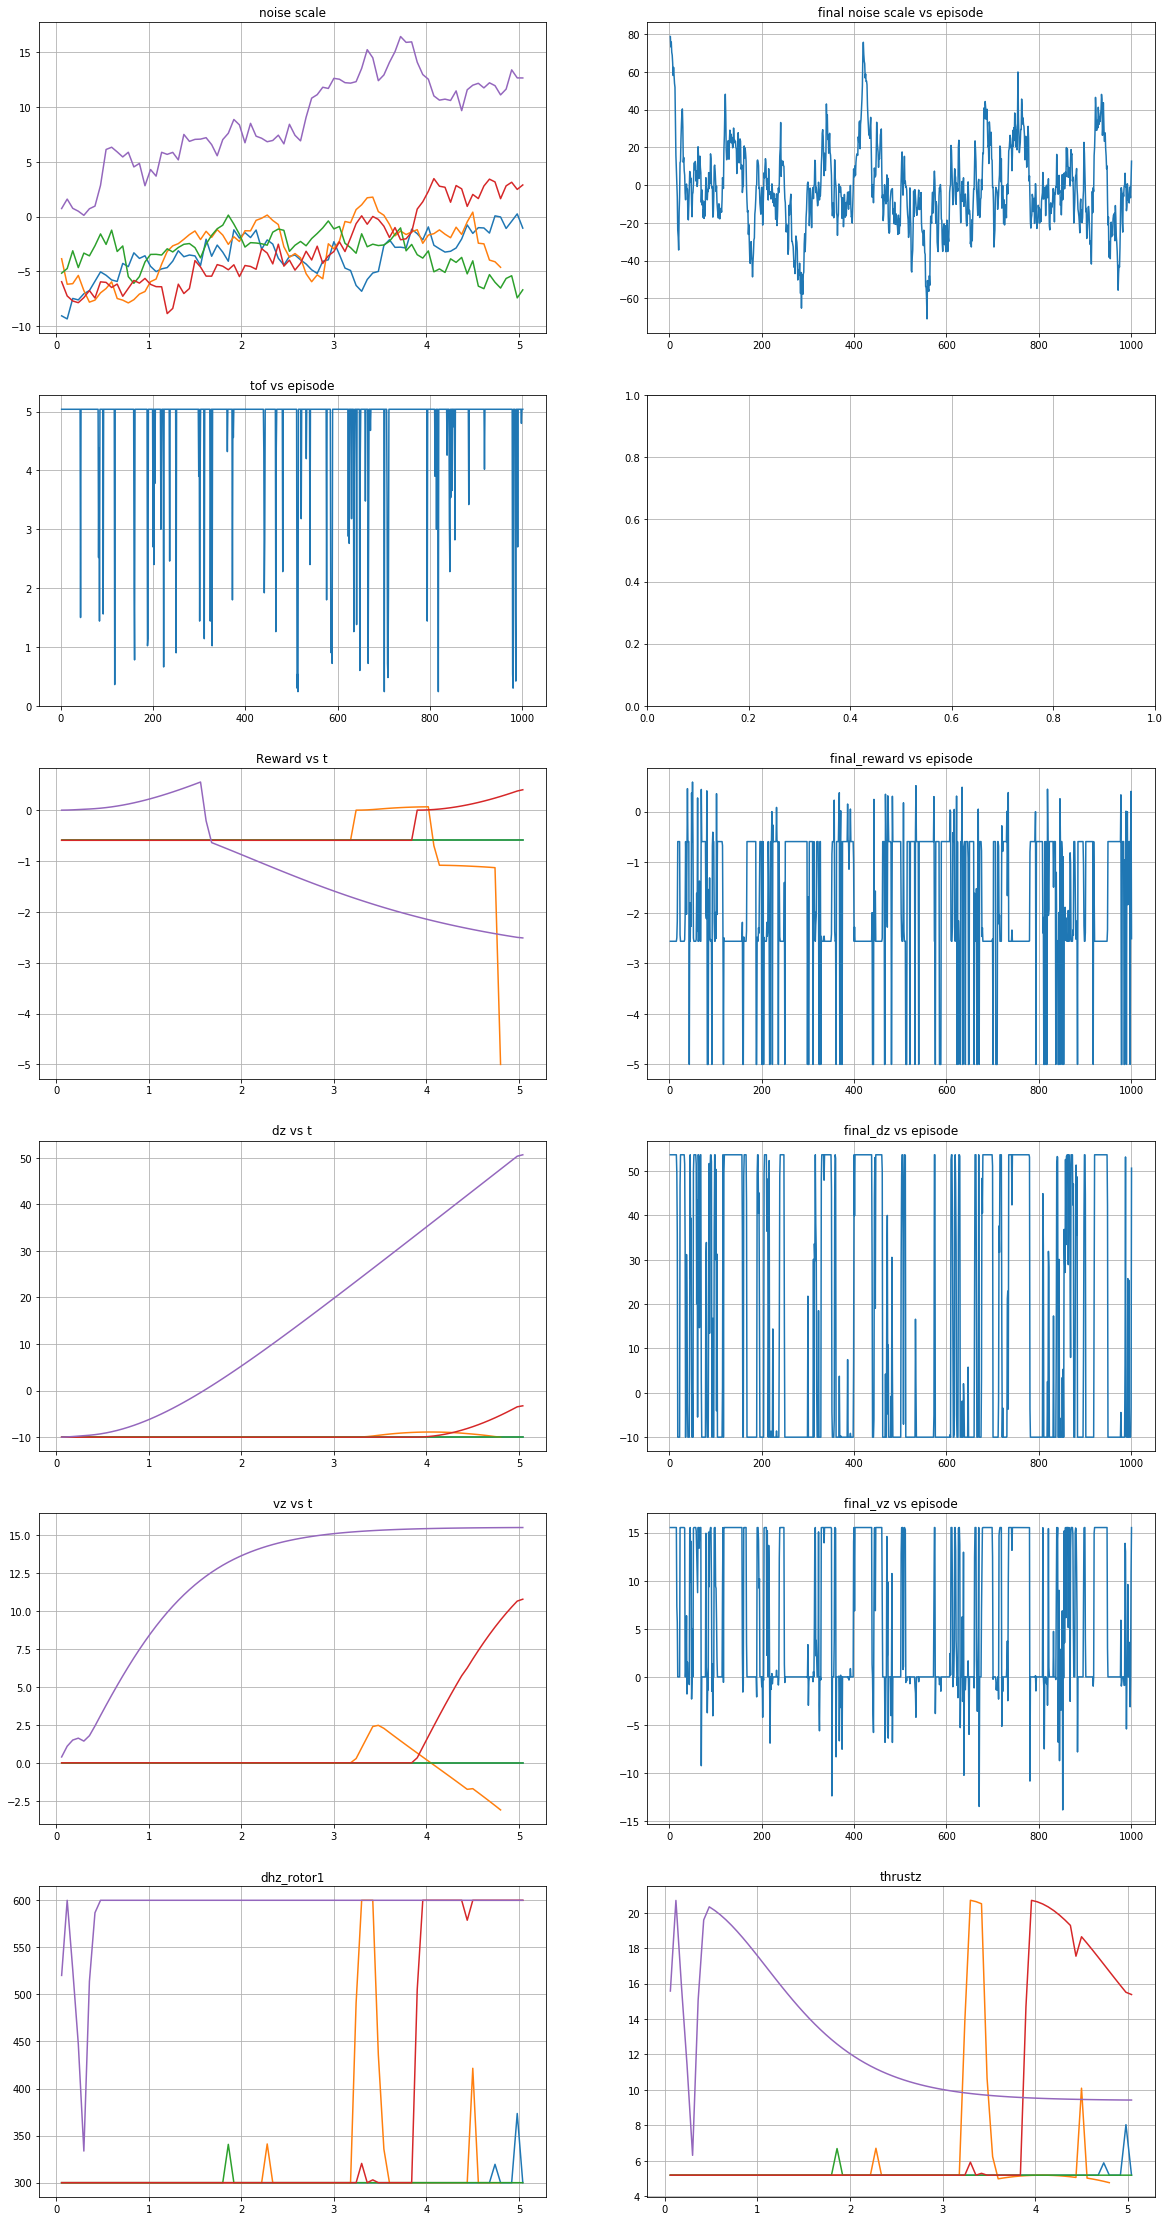

In [11]:
## TODO: Plot the rewards.
import matplotlib.pyplot as plt

titles = [
    ['noise scale', 'final noise scale vs episode'],
    ['tof vs episode', ''],
    ['Reward vs t', 'final_reward vs episode'],
    ['dz vs t','final_dz vs episode'],
    ['vz vs t','final_vz vs episode'],
    ['dhz_rotor1','thrustz']
]
nrows=len(titles)
ncols=len(titles[0])
fig, subs = plt.subplots(nrows,ncols,figsize=(20,40))
for i in range(nrows):
        for j in range(ncols):
            subs[i,j].set_title(titles[i][j])
            subs[i,j].grid()

#num_episodes = 105
totrange = range(num_episodes)

n=5
myrange = range(num_episodes-n,num_episodes)
#myrange = range(1,n)
#myrange = [180]
#myrange = totrange
#totrange = myrange

for i in myrange:
        #subs[0,0].plot(-np.log(-1*np.array(res[0]['rewards'])), label='Reward')
        subs[0,0].plot(res[i]['time'], res[i]['noise_scale'], label='noise_scale')
        subs[2,0].plot(res[i]['time'], res[i]['rewards'], label='Reward')
        subs[3,0].plot(res[i]['time'], res[i]['dz'], label='dz')
        subs[4,0].plot(res[i]['time'], res[i]['vz'], label='vz')
        subs[5,0].plot(res[i]['time'], res[i]['dhz_rotor1'], label='dv_rotor1')
        subs[5,1].plot(res[i]['time'], res[i]['thrustz'], label='thrustz')

episodes  = [res[i]['i_episode'][0]+1 for i in totrange]
noises    = [res[i]['noise_scale'][-1] for i in totrange]; subs[0,1].plot(episodes, noises, label='final_noise_scale')
tofs      = [res[i]['time'][-1] for i in totrange];      subs[1,0].plot(episodes, tofs, label='tof')
final_rwd = [res[i]['rewards'][-1] for i in totrange];   subs[2,1].plot(episodes, final_rwd, label='final_rwd')
final_zs  = [res[i]['dz'][-1] for i in totrange];        subs[3,1].plot(episodes, final_zs, label='final_dz')
final_vzs = [res[i]['vz'][-1] for i in totrange];        subs[4,1].plot(episodes, final_vzs, label='final_vz')
